# Setup

In [ ]:
import torch, spacy, fasttext
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from functions_rnn_model import tokenize, build_vocab_ft, encode_ft, eval_model, train_model, predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from random import shuffle
from matplotlib import pyplot as plt

In [ ]:
#Download spacy model
!python -m spacy download fr_dep_news_trf

In [ ]:
import torch
device = torch.device('cuda:0')
print("Device: {}".format(device))

Device: cuda:0


# Load data and final processing

### Import and process the translated PDTB
The PDTB is freely available at: https://github.com/cgpotts/pdtb2.
It was machine-translated from French to English using the open-source LibreTranslate API: https://libretranslate.com/?source=en&target=fr&q=

In [ ]:
pdtb = pd.read_csv('drive/MyDrive/Thesis/data/pdtb_translated.csv')

pdtb = pdtb[pdtb['clean_text_fr'] != 'Error']

#Slice the 2 arguments from the translation
pdtb['arg1_fr'] = pdtb['clean_text_fr'].apply(lambda x: x.split('\n')[0] if len(x.split('\n'))==2 else 'Error')
pdtb['arg2_fr'] = pdtb['clean_text_fr'].apply(lambda x: x.split('\n')[1] if len(x.split('\n'))==2 else 'Error')
pdtb = pdtb[(pdtb['arg1_fr']!='Error') & (pdtb['arg2_fr']!='Error')]

#Cleaning of pdtb

#Replace the badly decoded apostrophe
pdtb['arg1_fr'] = pdtb['arg1_fr'].apply(lambda x: x.replace(' &apos; ', "'" ))
pdtb['arg2_fr'] = pdtb['arg2_fr'].apply(lambda x: x.replace(' &apos; ', "'" ))

#Remove punctuation at the begining of the argument
pdtb['arg1_fr'] = pdtb['arg1_fr'].apply(lambda x: x[1:].strip() if (x[0]=='.' or x[0]==',' or x[0]==';' or x[0]==':') else x)
pdtb['arg2_fr'] = pdtb['arg2_fr'].apply(lambda x: x[1:].strip() if (x[0]=='.' or x[0]==',' or x[0]==';' or x[0]==':') else x)

#Binary dummy for explicit/implicit relations
pdtb['explicit'] = 0
pdtb.loc[pdtb['Connective_RawText'].isna()==False, 'explicit'] = 1

### Import and process the French corpus Explicadis

In [ ]:
explicadis = pd.read_excel('drive/My Drive/Thesis/data/explicadis_final.xlsx')

#Clean explicadis
explicadis['Arg1_raw'] = explicadis['Arg1_raw'].apply(lambda x: x.strip())
explicadis['Arg2_raw'] = explicadis['Arg2_raw'].apply(lambda x: x.strip())

explicadis['causal_type'] = 'Not causal'
explicadis.loc[explicadis['relation_type']=='result', 'causal_type'] = 'Result'
explicadis.loc[explicadis['relation_type']=='explanation', 'causal_type'] = 'Reason'

# Tokenization, encoding and train-test splitting

In [ ]:
import spacy
nlp = spacy.load('fr_dep_news_trf', disable=['morpholizer', 'parser', 'attribute_ruler', 'lemmatizer', 'transformer'])

The tokenize() function receives a list of argument pairs and tokenize the texts using SpaCy

In [ ]:
#Features for both datasets
X = [list(a) for a in zip(pdtb['arg1_fr'], pdtb['arg2_fr'])]
X_token = tokenize(X, nlp)

X_explicadis = [list(a) for a in zip(explicadis['Arg1_raw'], explicadis['Arg2_raw'])]
X_explicadis_token = tokenize(X_explicadis, nlp)

In [ ]:
#Targets for both datasets
y = pdtb['causal_type'].tolist()
y_explicadis = explicadis['causal_type'].tolist()

Split pdtb into train, val, test

In [ ]:
X_train_token, X_test_token, y_train, y_test = train_test_split(X_token, y, test_size=0.15, random_state=50, stratify=y)
X_train_token, X_val_token, y_train, y_val = train_test_split(X_train_token, y_train, test_size=0.1875, random_state=51, stratify=y_train)

print("The training dataset is of length: {}".format(str(len(X_train_token))))
print("The validation dataset is of length: {}".format(str(len(X_val_token))))
print("The test dataset is of length: {}".format(str(len(X_test_token))))

Pre-trained French fasttext embeddings are loaded. Embeddings contain 300 dimensions.

In [ ]:
fasttext = fasttext.load_model("drive/My Drive/Thesis/models/FastText/cc.fr.300.bin")

The function build_vocab_ft() builds a dictionary with all the unique words contained in the dataset and their corresponding fasttext word embeddings. It outputs a dictionary with a number ID for each word leading to the the word's respective embeddings in the embedding matrix.

In [ ]:
word_dic, fasttext_vectors = build_vocab_ft([X_explicadis_token, X_train_token, X_val_token, X_test_token], fasttext)

The function encode_ft() normalizes (truncates or pad) the length of each argument and maps tokens to their respective number IDs.


In [ ]:
X_train_encoded = np.array(encode_ft(X_train_token, word_dic, 50))
X_val_encoded = np.array(encode_ft(X_val_token, word_dic, 50))
X_test_encoded = np.array(encode_ft(X_test_token, word_dic, 50))
X_explicadis_encoded = np.array(encode_ft(X_explicadis_token, word_dic, 50))

The target data is encoded into the three classes

In [ ]:
y_train_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_train])
y_val_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_val])
y_test_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_test])
y_explicadis_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_explicadis])

The train datasets is resampled to mitigate class imbalances

In [ ]:
unique, counts = np.unique(y_train_encoded, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

oversample = RandomOverSampler(sampling_strategy={1:5000, 2:5000}, random_state = 73940)

x_os_id, y_os_id = oversample.fit_resample(X_train_encoded[:,:,0], y_train_encoded)
X_train_encoded_os = X_train_encoded[oversample.sample_indices_]
y_train_encoded_os = y_train_encoded[oversample.sample_indices_]

undersample = RandomUnderSampler(sampling_strategy={0:10000}, random_state = 73940)

x_us_id, y_us_id = undersample.fit_resample(X_train_encoded_os[:,:,0], y_train_encoded_os)
X_train_encoded_us = X_train_encoded_os[undersample.sample_indices_]
y_train_encoded_us = y_train_encoded_os[undersample.sample_indices_]

#Reshuffle the dataset
from random import shuffle

ind_list = [i for i in range(y_train_encoded_us.shape[0])]
shuffle(ind_list)
X_train_encoded_rs = X_train_encoded_us[ind_list,:,:]
y_train_encoded_rs = y_train_encoded_us[ind_list,]

#New distribution
unique, counts = np.unique(y_train_encoded_rs, return_counts=True)
print(np.asarray((unique, counts)).T)

# Model

The data is converted to torch tensors and sent to the GPU if available

In [ ]:
X_train_encoded_rs = torch.tensor(X_train_encoded_rs).to(device).to(torch.int64)
X_val_encoded = torch.tensor(X_val_encoded).to(device).to(torch.int64)
X_test_encoded = torch.tensor(X_test_encoded).to(device).to(torch.int64)
X_explicadis_encoded = torch.tensor(X_explicadis_encoded).to(device).to(torch.int64)

y_train_encoded_rs = torch.tensor(y_train_encoded_rs).to(device).to(torch.int64)
y_val_encoded = torch.tensor(y_val_encoded).to(device).to(torch.int64)
y_test_encoded = torch.tensor(y_test_encoded).to(device).to(torch.int64)
y_explicadis_encoded = torch.tensor(y_explicadis_encoded).to(device).to(torch.int64)

The model's parts are defined below. The general architecture was drawn from Bai & Zhao (2018). Code is available at: https://github.com/hxbai/Deep_Enhanced_Repr_for_IDRR


In [ ]:
class Config(object):
    def __init__(self, word_vectors):
      self.wordvec_dim = 300
      self.max_sent_len = 50

      ################################################################################
      #Embedding layer
      self.word_vectors = torch.FloatTensor(word_vectors).to(device)
      self.word_vectors_dim = word_vectors.shape[1]

      ################################################################################
      #RNN layer
      self.use_rnn = True
      self.embed_dropout = 0.3
      self.rnn_dropout = 0.3
      self.rnn_dim = self.word_vectors_dim
      self.rnn_layer_num = 1

      ################################################################################
      # Attention
      self.attn_dropout = 0.3

      ################################################################################
      #CNN Layer
      self.nb_filter = 200
      self.filter_size1 = 3
      self.filter_size2 = 4
      self.filter_size3 = 5
      self.topk = 10

      ################################################################################
      # Classifier
      self.classifier_class_num = 3
      self.classifier_dropout = 0.4
      self.classifier_input_size = 200 * self.topk
      self.linear_layer_size1 = 1200
      self.linear_layer_size2 = 1200

config = Config(word_vectors=fasttext_vectors)

In [ ]:
class RNNLayer(nn.Module):
    def __init__(self, in_dim, conf):
        super(RNNLayer, self).__init__()
        self.conf = conf
        self.rnn = nn.GRU(in_dim, in_dim, num_layers=1, batch_first=True,
                            dropout=self.conf.rnn_dropout, bidirectional=True)
        self.conv = nn.Conv1d(in_dim*2, in_dim, 1)
        nn.init.xavier_uniform(self.conv.weight)
        self.conv.bias.data.fill_(0)
        self.dropout = nn.Dropout(self.conf.rnn_dropout)

    def forward(self, input, hidden=None):
        outputs, hidden_t = self.rnn(input)
        outputs = self.conv(self.dropout(outputs.transpose(1, 2))).transpose(1, 2)
        return outputs + input

In [ ]:
class Atten(nn.Module):
    def __init__(self, conf):
        super(Atten, self).__init__()
        self.conf = conf
        self.w = nn.Conv1d(self.conf.rnn_dim, self.conf.rnn_dim, 1)
        self.temper = np.power(self.conf.rnn_dim, 0.5)
        self.dropout = nn.Dropout(self.conf.attn_dropout)
        self.softmax = nn.Softmax(-1)

    def forward(self, q, v):
        q_ = self.w(q.transpose(1, 2)).transpose(1, 2)
        attn = torch.bmm(q_, v.transpose(1, 2)) / self.temper

        vr = torch.bmm(self.dropout(self.softmax(attn)), v)
        qr = torch.bmm(self.dropout(self.softmax(attn.transpose(1, 2))), q)
        return qr, vr, attn

In [ ]:
#All inputs, vectors, and args should be converted to torch tensors!

class Arg_encoder(nn.Module):
  def __init__(self, conf, attention_vis=False):
    super(Arg_encoder, self).__init__()
    self.conf = conf
    self.attention_vis = attention_vis
    self.embedding = nn.Embedding.from_pretrained(self.conf.word_vectors, freeze=True)
    
    self.dropout = nn.Dropout(self.conf.embed_dropout)

    #RNN layer
    self.rnn_layer1 = nn.ModuleList()
    self.rnn_layer2 = nn.ModuleList()
    for i in range(self.conf.rnn_layer_num):
      self.rnn_layer1.append(RNNLayer(self.conf.rnn_dim, self.conf))
      self.rnn_layer2.append(RNNLayer(self.conf.rnn_dim, self.conf))
    
    #Bi_attention
    self.attention = Atten(conf)

  def forward(self, args):
    #Embedding layers
    arg1_embeddings = self.embedding(args[:,0,:])
    arg2_embeddings = self.embedding(args[:,1,:])

    #Representation dropout
    arg1_rep = self.dropout(arg1_embeddings)
    arg2_rep = self.dropout(arg2_embeddings)

    #RNN encoding
    outputs = []
    attention_coefs = []
    for i in range(self.conf.rnn_layer_num):
      arg1_rep = self.rnn_layer1[i](arg1_rep)
      arg2_rep = self.rnn_layer2[i](arg2_rep)

      arg1_output, arg2_output, attention = self.attention(arg1_rep, arg2_rep)
      outputs.append(arg1_output)
      outputs.append(arg2_output)
      attention_coefs.append(attention)
    if self.attention_vis == True:
      return torch.cat(outputs, 1), attention_coefs
    else:
      return torch.cat(outputs, 1)

In [ ]:
class CNN_layer(nn.Module):
  def __init__(self, conf):
    super(CNN_layer, self).__init__()
    self.conf = conf

    self.cnn_layer1 = nn.Conv1d(in_channels = 300, out_channels = 250, kernel_size=self.conf.filter_size1)
    self.batch_norm1 = nn.BatchNorm1d(250)
    self.ReLu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool1d(3,stride=1)
    
    self.cnn_layer2 = nn.Conv1d(in_channels = 250, out_channels = 200, kernel_size=self.conf.filter_size2)
    self.batch_norm2 = nn.BatchNorm1d(200)
    self.ReLu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool1d(3,stride=1)


    self.cnn_layer3 = nn.Conv1d(in_channels = 200, out_channels = 200, kernel_size=self.conf.filter_size3)
    self.batch_norm3 = nn.BatchNorm1d(200)
    self.ReLu3 = nn.ReLU()

  def forward(self, arg):
    arg = torch.transpose(arg,1,2)

    cnn_output1 = self.cnn_layer1(arg)
    cnn_output1 = self.ReLu1(cnn_output1)
    cnn_output1 = self.maxpool1(cnn_output1)
    
    cnn_output2 = self.cnn_layer2(cnn_output1)
    cnn_output2 = self.ReLu2(cnn_output2)
    cnn_output2 = self.maxpool2(cnn_output2)

    cnn_output3 = self.cnn_layer3(cnn_output2)
    cnn_output3 = self.ReLu3(cnn_output3)

    final_output = torch.topk(cnn_output3, k=self.conf.topk, dim=2)[0]
    final_output = torch.flatten(final_output, start_dim=1, end_dim=2)

    return final_output

In [ ]:
class Arg_classifier(nn.Module):
  def __init__(self, conf):
    super(Arg_classifier, self).__init__()
    self.conf = conf
    self.dropout = nn.Dropout(self.conf.classifier_dropout)
    self.Linear1 = nn.Linear(self.conf.classifier_input_size, self.conf.linear_layer_size1)
    self.Linear2 = nn.Linear(self.conf.linear_layer_size1, self.conf.linear_layer_size2)
    self.Linear3 = nn.Linear(self.conf.linear_layer_size2, self.conf.classifier_class_num)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(-1)

  def forward(self, input):
    l1_output = self.Linear1(input)
    l1_output = self.dropout(l1_output)
    l1_output = self.relu(l1_output)

    l2_output = self.Linear2(l1_output)
    l2_output = self.dropout(l2_output)
    l2_output = self.relu(l2_output)

    l3_output = self.Linear3(l2_output)
    l3_output = self.dropout(l3_output)

    return l3_output

In [ ]:
class FullModel(nn.Module):
  def __init__(self, conf):
    super(FullModel, self).__init__()
    self.conf = conf
    self.encoder = Arg_encoder(self.conf)
    self.cnn = CNN_layer(self.conf)
    self.classifier = Arg_classifier(self.conf)

  def forward(self, args):
    encoded_args = self.encoder(args)
    cnn_args = self.cnn(encoded_args)
    class_args = self.classifier(cnn_args)
    return class_args

## Fine tuning

Two hyper-parameters are fine tuned using a grid search approach:


*   Learning rate: 0.0001, 0.0005, 0.001
*   Weight decay (L2 regularization): 0.00001, 0.00005, 0.0001



The best performing combination is found to be a learning rate of 0.0005 and a wight decay of 0.00001

In [ ]:
lr = 0.0005
wd = 0.00001

The model is then trained over 100 epochs to determine the optimal training time before overfitting

In [ ]:
model = FullModel(config)
model = model.to(device)

loss_history, val_loss_history, f1_history, val_f1_history = train_model(model, X_train_encoded_rs, y_train_encoded_rs, X_val_encoded, y_val_encoded, batch_size=100, num_epochs=100, lr=lr, wd=wd)

Training...
Currently training epoch 0 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.755927374213934 on train set and 0.5670241328802976 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 1 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6785822288443645 on train set and 0.6162548856301742 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 2 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6768732878069083 on train set and 0.5621935188770294 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 3 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6702074660609166 on train set and 0.625593667680567 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 4 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6683230559031169 on train set and 0.54835411418568 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 5 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6635999345531066 on train set and 0.5797708262096751 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 6 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6648534170041481 on train set and 0.5243248283863068 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 7 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6503073800355196 on train set and 0.5470367924733596 on validation set 

F1 is 0.09616749467707593 on train set and 0.1035548686244204 on validation set 

Currently training epoch 8 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6478473381449779 on train set and 0.5115074986761267 on validation set 

F1 is 0.1705921938088829 on train set and 0.16717325227963525 on validation set 

Currently training epoch 9 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6269267274687688 on train set and 0.4946617229418321 on validation set 

F1 is 0.1705982905982906 on train set and 0.16845329249617153 on validation set 

Currently training epoch 10 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6212571750084559 on train set and 0.49062199321660127 on validation set 

F1 is 0.18033322443645866 on train set and 0.17982456140350878 on validation set 

Currently training epoch 11 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6174045612414678 on train set and 0.522594131122936 on validation set 

F1 is 0.19875248086192232 on train set and 0.2 on validation set 

Currently training epoch 12 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6154694803059101 on train set and 0.46663703539154744 on validation set 

F1 is 0.17029972752043598 on train set and 0.17073170731707316 on validation set 

Currently training epoch 13 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6134805000076692 on train set and 0.4887863977388902 on validation set 

F1 is 0.17325227963525835 on train set and 0.177710843373494 on validation set 

Currently training epoch 14 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6042846029003461 on train set and 0.47668626796115526 on validation set 

F1 is 0.1930043722673329 on train set and 0.19694868238557559 on validation set 

Currently training epoch 15 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6022981805106004 on train set and 0.46718482971191405 on validation set 

F1 is 0.1846861649687808 on train set and 0.18740849194729137 on validation set 

Currently training epoch 16 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5985263721396525 on train set and 0.49403927434574474 on validation set 

F1 is 0.19407687460617518 on train set and 0.19778699861687413 on validation set 

Currently training epoch 17 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.594155824681123 on train set and 0.4770875551483848 on validation set 

F1 is 0.1798392498325519 on train set and 0.18479880774962745 on validation set 

Currently training epoch 18 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5892316188663245 on train set and 0.46448175473646686 on validation set 

F1 is 0.17900403768506057 on train set and 0.18263473053892218 on validation set 

Currently training epoch 19 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5867577739059925 on train set and 0.46235043948346916 on validation set 

F1 is 0.180597515944948 on train set and 0.17964071856287425 on validation set 

Currently training epoch 20 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.58219747915864 on train set and 0.4563077509403229 on validation set 

F1 is 0.20277191925278698 on train set and 0.2047556142668428 on validation set 

Currently training epoch 21 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.58302369688948 on train set and 0.47854592800140383 on validation set 

F1 is 0.17768037761294672 on train set and 0.18535127055306427 on validation set 

Currently training epoch 22 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.577107189844052 on train set and 0.46472109231081876 on validation set 

F1 is 0.17986577181208052 on train set and 0.18479880774962745 on validation set 

Currently training epoch 23 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5671371903270483 on train set and 0.4417234399101951 on validation set 

F1 is 0.19621266730141515 on train set and 0.2 on validation set 

Currently training epoch 24 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5680168232570092 on train set and 0.46539533029903063 on validation set 

F1 is 0.18172690763052207 on train set and 0.1908284023668639 on validation set 

Currently training epoch 25 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5661056946963072 on train set and 0.459412576935508 on validation set 

F1 is 0.21717766656834833 on train set and 0.21996542783059636 on validation set 

Currently training epoch 26 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5633229016015927 on train set and 0.4547164971178228 on validation set 

F1 is 0.20162047411251327 on train set and 0.20571428571428574 on validation set 

Currently training epoch 27 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5660348215450843 on train set and 0.43497743660753424 on validation set 

F1 is 0.22617978515347037 on train set and 0.2201864670710881 on validation set 

Currently training epoch 28 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5556827859332164 on train set and 0.4423655011437156 on validation set 

F1 is 0.23499766293991287 on train set and 0.2137946986543737 on validation set 

Currently training epoch 29 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5535745499034722 on train set and 0.43120377388867465 on validation set 

F1 is 0.28995707313248525 on train set and 0.2666093928980527 on validation set 

Currently training epoch 30 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5456758874158064 on train set and 0.4424527097832073 on validation set 

F1 is 0.24361426542768017 on train set and 0.22540761578374993 on validation set 

Currently training epoch 31 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5532249465584755 on train set and 0.430742976882241 on validation set 

F1 is 0.2687807566036348 on train set and 0.252388646356052 on validation set 

Currently training epoch 32 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5417395256459713 on train set and 0.43707321394573556 on validation set 

F1 is 0.27430137257711573 on train set and 0.24672583279405874 on validation set 

Currently training epoch 33 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5481463437279065 on train set and 0.42945321202278136 on validation set 

F1 is 0.2434399082379075 on train set and 0.23125406258705544 on validation set 

Currently training epoch 34 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5427146796137094 on train set and 0.42129203948107635 on validation set 

F1 is 0.32213557431209305 on train set and 0.303798713503297 on validation set 

Currently training epoch 35 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5348024388154348 on train set and 0.42631540461020034 on validation set 

F1 is 0.31830535952698835 on train set and 0.28563146091998026 on validation set 

Currently training epoch 36 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5390568432708581 on train set and 0.41991682106798345 on validation set 

F1 is 0.33308419335453643 on train set and 0.2809381290297563 on validation set 

Currently training epoch 37 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5397209865351518 on train set and 0.41706914739175277 on validation set 

F1 is 0.3136151498319294 on train set and 0.2902910362577521 on validation set 

Currently training epoch 38 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5364403783033291 on train set and 0.4228957994417711 on validation set 

F1 is 0.33651552041851956 on train set and 0.2991282689912827 on validation set 

Currently training epoch 39 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5291449595242739 on train set and 0.43321928652850067 on validation set 

F1 is 0.33274685779292873 on train set and 0.27947606483226534 on validation set 

Currently training epoch 40 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5312815446406602 on train set and 0.4281646885655143 on validation set 

F1 is 0.25795053968375325 on train set and 0.24363560889090158 on validation set 

Currently training epoch 41 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5328076403588057 on train set and 0.41875998323613944 on validation set 

F1 is 0.3279745471904373 on train set and 0.29226441631504924 on validation set 

Currently training epoch 42 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5245616197586059 on train set and 0.42375540028918873 on validation set 

F1 is 0.3653072548203634 on train set and 0.33444825982405274 on validation set 

Currently training epoch 43 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5198137747744719 on train set and 0.4533909873528914 on validation set 

F1 is 0.3872430233069055 on train set and 0.3213839891451832 on validation set 

Currently training epoch 44 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5255803473293781 on train set and 0.4281673333861611 on validation set 

F1 is 0.31822841318930095 on train set and 0.26548563103860584 on validation set 

Currently training epoch 45 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5246007754156987 on train set and 0.41715994477272034 on validation set 

F1 is 0.3490119806058378 on train set and 0.3234653277756726 on validation set 

Currently training epoch 46 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5203687851627667 on train set and 0.43429204442284325 on validation set 

F1 is 0.37085848279008204 on train set and 0.3400837484658148 on validation set 

Currently training epoch 47 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5219607941806317 on train set and 0.4284528710625388 on validation set 

F1 is 0.3578476763468785 on train set and 0.3287020422113988 on validation set 

Currently training epoch 48 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5131707883129517 on train set and 0.44898699196902186 on validation set 

F1 is 0.3869969040247678 on train set and 0.3402263310865129 on validation set 

Currently training epoch 49 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5108036837230127 on train set and 0.4475708024068312 on validation set 

F1 is 0.3996747845759723 on train set and 0.32654256094260675 on validation set 

Currently training epoch 50 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5067274523278077 on train set and 0.446640376069329 on validation set 

F1 is 0.35313823823622215 on train set and 0.2984576101583797 on validation set 

Currently training epoch 51 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5071867695699136 on train set and 0.44852661652998493 on validation set 

F1 is 0.384966025345447 on train set and 0.334822044759933 on validation set 

Currently training epoch 52 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5066074983527263 on train set and 0.43813562176444315 on validation set 

F1 is 0.4283066298754306 on train set and 0.3567580255745328 on validation set 

Currently training epoch 53 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5090651606520017 on train set and 0.43305675170638347 on validation set 

F1 is 0.40130954190550444 on train set and 0.3490786240786241 on validation set 

Currently training epoch 54 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5043975042800108 on train set and 0.4660114114934748 on validation set 

F1 is 0.38803075115136276 on train set and 0.34098642159824466 on validation set 

Currently training epoch 55 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.505280697097381 on train set and 0.4550323237072338 on validation set 

F1 is 0.3995475114498893 on train set and 0.349232843294601 on validation set 

Currently training epoch 56 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5008442796766758 on train set and 0.43812872713262385 on validation set 

F1 is 0.3922675103001766 on train set and 0.30720464510013035 on validation set 

Currently training epoch 57 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4980950642377138 on train set and 0.43942937363277784 on validation set 

F1 is 0.4466602802396316 on train set and 0.36589499977697487 on validation set 

Currently training epoch 58 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.49366548446317515 on train set and 0.4536004575816068 on validation set 

F1 is 0.40721367623641613 on train set and 0.34464231661789935 on validation set 

Currently training epoch 59 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4976800616830587 on train set and 0.45952744809064 on validation set 

F1 is 0.40445242373350204 on train set and 0.34514638866346214 on validation set 

Currently training epoch 60 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4878702158729235 on train set and 0.4396665388887579 on validation set 

F1 is 0.4553455421961966 on train set and 0.36837574310048427 on validation set 

Currently training epoch 61 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4895514141768217 on train set and 0.47844892090017144 on validation set 

F1 is 0.43569362836511716 on train set and 0.3648312119535141 on validation set 

Currently training epoch 62 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4892312383900086 on train set and 0.4473646060986952 on validation set 

F1 is 0.39660419820230136 on train set and 0.31156186372460815 on validation set 

Currently training epoch 63 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.48244128860533236 on train set and 0.4455748904835094 on validation set 

F1 is 0.39054821700369646 on train set and 0.32237566720325345 on validation set 

Currently training epoch 64 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4869545636077722 on train set and 0.49158216389742765 on validation set 

F1 is 0.4665182191642291 on train set and 0.3441367044847104 on validation set 

Currently training epoch 65 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4829593782623609 on train set and 0.449174422567541 on validation set 

F1 is 0.46802930645361496 on train set and 0.367621922741739 on validation set 

Currently training epoch 66 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.477957271784544 on train set and 0.4655787457119335 on validation set 

F1 is 0.4509144237405107 on train set and 0.3652173913043478 on validation set 

Currently training epoch 67 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4758748020976782 on train set and 0.47691743698987094 on validation set 

F1 is 0.406725729344116 on train set and 0.33657689394172674 on validation set 

Currently training epoch 68 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4764496179918448 on train set and 0.4844359825957905 on validation set 

F1 is 0.47157611693325974 on train set and 0.3390714972931834 on validation set 

Currently training epoch 69 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4779406629502773 on train set and 0.46656340469013563 on validation set 

F1 is 0.4767185647676753 on train set and 0.3698176692088092 on validation set 

Currently training epoch 70 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4680584229528904 on train set and 0.4688293099403381 on validation set 

F1 is 0.47421636023301683 on train set and 0.3602404138770542 on validation set 

Currently training epoch 71 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46657232331732906 on train set and 0.47507973692633887 on validation set 

F1 is 0.5003452305077545 on train set and 0.3572024822024822 on validation set 

Currently training epoch 72 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4599535652746757 on train set and 0.5117724562233145 on validation set 

F1 is 0.5144661860503499 on train set and 0.36823409148990544 on validation set 

Currently training epoch 73 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4604614577566584 on train set and 0.5552741955627095 on validation set 

F1 is 0.4727296031795844 on train set and 0.3563164246093915 on validation set 

Currently training epoch 74 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46692468635737894 on train set and 0.5404896990819411 on validation set 

F1 is 0.5160708306866221 on train set and 0.3718826149009278 on validation set 

Currently training epoch 75 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46420191663006943 on train set and 0.49925179102204065 on validation set 

F1 is 0.5323918148431053 on train set and 0.3803070937523608 on validation set 

Currently training epoch 76 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4559135482956966 on train set and 0.4897557708350095 on validation set 

F1 is 0.5633148071188798 on train set and 0.3742046010768477 on validation set 

Currently training epoch 77 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.460414478306969 on train set and 0.48664600036361 on validation set 

F1 is 0.523238618597125 on train set and 0.36551894056051737 on validation set 

Currently training epoch 78 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4576129193107287 on train set and 0.4993251367048784 on validation set 

F1 is 0.5281267052078701 on train set and 0.3686848211014776 on validation set 

Currently training epoch 79 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4529837061961492 on train set and 0.5096989745443518 on validation set 

F1 is 0.5392518385040294 on train set and 0.37719674617594456 on validation set 

Currently training epoch 80 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4477061565965414 on train set and 0.48324191299351776 on validation set 

F1 is 0.5473228171517441 on train set and 0.3688396036680997 on validation set 

Currently training epoch 81 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.44410009669760864 on train set and 0.5119422928853469 on validation set 

F1 is 0.5963520170416721 on train set and 0.3846473318737659 on validation set 

Currently training epoch 82 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.443318735063076 on train set and 0.529735083471645 on validation set 

F1 is 0.5170347948197846 on train set and 0.36015380535666935 on validation set 

Currently training epoch 83 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.44002671353518963 on train set and 0.48982651992277665 on validation set 

F1 is 0.5941161330484177 on train set and 0.37947666758195564 on validation set 

Currently training epoch 84 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4388246420770884 on train set and 0.6365548794919794 on validation set 

F1 is 0.5983917012249882 on train set and 0.3882061283051381 on validation set 

Currently training epoch 85 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.43528011900683244 on train set and 0.5255924089388414 on validation set 

F1 is 0.6232935862091873 on train set and 0.3838536136476251 on validation set 

Currently training epoch 86 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4354662157595158 on train set and 0.517497703703967 on validation set 

F1 is 0.5734473860009492 on train set and 0.36007851500024235 on validation set 

Currently training epoch 87 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4358155169834693 on train set and 0.567688262462616 on validation set 

F1 is 0.5704644574319374 on train set and 0.36546565528866415 on validation set 

Currently training epoch 88 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4315046986564994 on train set and 0.5311723234978589 on validation set 

F1 is 0.6062986796494828 on train set and 0.3660372194854954 on validation set 

Currently training epoch 89 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4298837794611851 on train set and 0.5290215167132291 on validation set 

F1 is 0.6292342422686061 on train set and 0.3823644357596483 on validation set 

Currently training epoch 90 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4257915234193206 on train set and 0.5744972014969045 on validation set 

F1 is 0.5291181302235144 on train set and 0.3429803654522755 on validation set 

Currently training epoch 91 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.42074571549892426 on train set and 0.5634134260090915 on validation set 

F1 is 0.6206646161151114 on train set and 0.36774387675272313 on validation set 

Currently training epoch 92 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4210998157660166 on train set and 0.594446181438186 on validation set 

F1 is 0.6161137503046308 on train set and 0.3691291054736997 on validation set 

Currently training epoch 93 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4151476507385572 on train set and 0.5900343179702758 on validation set 

F1 is 0.6350589959699936 on train set and 0.3692517832751556 on validation set 

Currently training epoch 94 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.41579654390613235 on train set and 0.5882274015383286 on validation set 

F1 is 0.6399598709575891 on train set and 0.3404185268592048 on validation set 

Currently training epoch 95 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.41836886256933215 on train set and 0.7075848693197424 on validation set 

F1 is 0.6073417000749702 on train set and 0.3628096906785432 on validation set 

Currently training epoch 96 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.41146338215718664 on train set and 0.6748076357624747 on validation set 

F1 is 0.6830616055070801 on train set and 0.3569976067590321 on validation set 

Currently training epoch 97 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.40638266019523145 on train set and 0.5256875352426009 on validation set 

F1 is 0.7604640260767599 on train set and 0.3990806838488957 on validation set 

Currently training epoch 98 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.40517085368434586 on train set and 0.5666531546549364 on validation set 

F1 is 0.644137948266033 on train set and 0.36444655381532454 on validation set 

Currently training epoch 99 of 100


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4019982398798068 on train set and 0.5893028606068004 on validation set 

F1 is 0.6638438676569189 on train set and 0.37034006866278374 on validation set 

Training done.


Plot of the training and validation F1-scores. Beyond 75 epochs, the model's overfitting becomes large and start affecting negatively performances on the validation set.

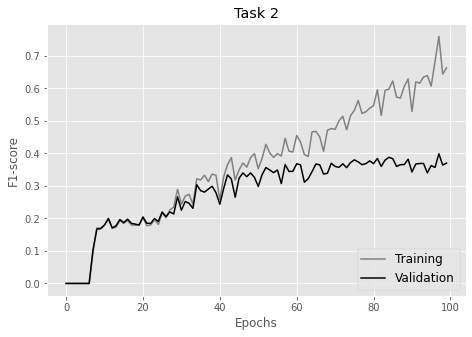

In [ ]:
training_stats = (loss_history, val_loss_history, f1_history, val_f1_history)
loss_history = stats[0]
val_loss_history = stats[1]
f1_history = stats[2]
val_f1_history = stats[3]

plt.style.use('ggplot')
plt.figure(figsize = (7.5, 5))
plt.plot(f1_history, label='Training', color='gray')
plt.plot(val_f1_history, label='Validation', color='black')
plt.legend(loc="lower right", prop={"size":12})
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('Task 2')
plt.show()

# Final model training

The model is trained using the set of finetuned hyperparameters over 75 epochs

In [ ]:
#Create a new instance of the model
model = FullModel(config)
model = model.to(device)

#Best hyper parameters
lr = 0.0005
wd = 0.00001

#Train the model with the finetuned hyperparameters for 75 epochs
loss_history, val_loss_history, f1_history, val_f1_history = train_model(model, X_train_encoded_rs, y_train_encoded_rs, X_val_encoded, y_val_encoded, batch_size=100, num_epochs=75, lr=lr, wd=wd)

Training...
Currently training epoch 0 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.7326741136610508 on train set and 0.5334765526381406 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 1 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6808829826613267 on train set and 0.5464963511987166 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 2 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6711026399085919 on train set and 0.551860427314585 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 3 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.665169245749712 on train set and 0.5258346969431097 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 4 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6696033594508966 on train set and 0.5565219434824857 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 5 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6630151064445575 on train set and 0.5327607436613603 on validation set 

F1 is 0.0 on train set and 0.0 on validation set 

Currently training epoch 6 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6539757830401262 on train set and 0.5128251211209731 on validation set 

F1 is 0.10636808957312807 on train set and 0.11419753086419752 on validation set 

Currently training epoch 7 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6413268957287073 on train set and 0.5332703081044283 on validation set 

F1 is 0.19076655052264807 on train set and 0.18911917098445596 on validation set 

Currently training epoch 8 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6291893934210141 on train set and 0.4749525628306649 on validation set 

F1 is 0.16568661362850223 on train set and 0.16307692307692306 on validation set 

Currently training epoch 9 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6197842779258887 on train set and 0.47100433219562876 on validation set 

F1 is 0.17394247038917088 on train set and 0.1749622926093514 on validation set 

Currently training epoch 10 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6183743247141441 on train set and 0.46796470609578217 on validation set 

F1 is 0.16907216494845362 on train set and 0.16946564885496182 on validation set 

Currently training epoch 11 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6106459477295478 on train set and 0.4610565207221291 on validation set 

F1 is 0.16637901277183295 on train set and 0.16436251920122888 on validation set 

Currently training epoch 12 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6078916123757759 on train set and 0.48259497122331096 on validation set 

F1 is 0.17361817565276366 on train set and 0.17797888386123678 on validation set 

Currently training epoch 13 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5991744173069795 on train set and 0.48205194310708477 on validation set 

F1 is 0.15645782289114457 on train set and 0.14353312302839116 on validation set 

Currently training epoch 14 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.6023399154345195 on train set and 0.46230826648798856 on validation set 

F1 is 0.1704974271012007 on train set and 0.16564417177914106 on validation set 

Currently training epoch 15 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.590279916053017 on train set and 0.44867387305606493 on validation set 

F1 is 0.17435549525101762 on train set and 0.17797888386123678 on validation set 

Currently training epoch 16 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5857388243079186 on train set and 0.44572055285627193 on validation set 

F1 is 0.170388182755067 on train set and 0.16282642089093702 on validation set 

Currently training epoch 17 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5904019884765148 on train set and 0.4441085018894889 on validation set 

F1 is 0.17217865666553017 on train set and 0.17298937784522003 on validation set 

Currently training epoch 18 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5833218824118376 on train set and 0.4410762689330361 on validation set 

F1 is 0.17336512261580383 on train set and 0.17549167927382753 on validation set 

Currently training epoch 19 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5838630565752586 on train set and 0.5136846276846799 on validation set 

F1 is 0.17426820966643974 on train set and 0.17298937784522003 on validation set 

Currently training epoch 20 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5799786758919557 on train set and 0.43929223743352025 on validation set 

F1 is 0.17823450134770888 on train set and 0.18208955223880596 on validation set 

Currently training epoch 21 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5755088704327742 on train set and 0.44766091325066304 on validation set 

F1 is 0.17708685366677931 on train set and 0.17620481927710843 on validation set 

Currently training epoch 22 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5779535322139661 on train set and 0.4375739027153362 on validation set 

F1 is 0.18086500655307994 on train set and 0.18759018759018758 on validation set 

Currently training epoch 23 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5677344349523386 on train set and 0.44478161605921657 on validation set 

F1 is 0.16963673749143246 on train set and 0.16920731707317072 on validation set 

Currently training epoch 24 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5756561340143284 on train set and 0.44443735426122494 on validation set 

F1 is 0.16861263736263737 on train set and 0.16539050535987748 on validation set 

Currently training epoch 25 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5660710650185744 on train set and 0.5203965512188998 on validation set 

F1 is 0.17241379310344826 on train set and 0.17522658610271905 on validation set 

Currently training epoch 26 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5661203645169735 on train set and 0.4388707854531028 on validation set 

F1 is 0.17537313432835822 on train set and 0.17894736842105263 on validation set 

Currently training epoch 27 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5657527714967727 on train set and 0.4367854486812245 on validation set 

F1 is 0.17601334497380894 on train set and 0.17522658610271905 on validation set 

Currently training epoch 28 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5590873255083958 on train set and 0.45203560428185896 on validation set 

F1 is 0.1904919296847249 on train set and 0.19307095805886768 on validation set 

Currently training epoch 29 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5573233675211668 on train set and 0.4361187040805817 on validation set 

F1 is 0.1975231950197517 on train set and 0.1947787683671785 on validation set 

Currently training epoch 30 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5619937716672818 on train set and 0.4473046113144268 on validation set 

F1 is 0.22286820497801374 on train set and 0.23022757505516128 on validation set 

Currently training epoch 31 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5615152361492316 on train set and 0.43511985052715646 on validation set 

F1 is 0.2170949697829331 on train set and 0.21993453700770774 on validation set 

Currently training epoch 32 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5453959251443545 on train set and 0.44565788940949874 on validation set 

F1 is 0.23110835068746727 on train set and 0.23057979445414 on validation set 

Currently training epoch 33 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5571333860357602 on train set and 0.47416557507081464 on validation set 

F1 is 0.21467551473386753 on train set and 0.21326726342710994 on validation set 

Currently training epoch 34 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5463489131381114 on train set and 0.4470614628358321 on validation set 

F1 is 0.29755787581273524 on train set and 0.27190517998244074 on validation set 

Currently training epoch 35 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5399339813739061 on train set and 0.42366787141019646 on validation set 

F1 is 0.277879321560601 on train set and 0.25230671085593365 on validation set 

Currently training epoch 36 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5346544774870078 on train set and 0.4281409057703885 on validation set 

F1 is 0.3334291823579359 on train set and 0.316375766561089 on validation set 

Currently training epoch 37 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5365962165097395 on train set and 0.4472507428039204 on validation set 

F1 is 0.31247159596119267 on train set and 0.29943823495168237 on validation set 

Currently training epoch 38 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5375551172842582 on train set and 0.43131498911164023 on validation set 

F1 is 0.3038690044921026 on train set and 0.2926639989407559 on validation set 

Currently training epoch 39 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.531137531499068 on train set and 0.43447137095711447 on validation set 

F1 is 0.32959590630545543 on train set and 0.30124834337993245 on validation set 

Currently training epoch 40 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5288091546545426 on train set and 0.42894916371865704 on validation set 

F1 is 0.3097118831982261 on train set and 0.29238505747126436 on validation set 

Currently training epoch 41 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5284315993388494 on train set and 0.4167741038582542 on validation set 

F1 is 0.34739710789766404 on train set and 0.32067698550883594 on validation set 

Currently training epoch 42 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5295980289578438 on train set and 0.4154351575808092 on validation set 

F1 is 0.33012505797497727 on train set and 0.3029953095818542 on validation set 

Currently training epoch 43 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5217558979988098 on train set and 0.4237118292938579 on validation set 

F1 is 0.3415147126948288 on train set and 0.3056870617846228 on validation set 

Currently training epoch 44 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5231517052898804 on train set and 0.438293212110346 on validation set 

F1 is 0.33735355534866235 on train set and 0.3163841807909604 on validation set 

Currently training epoch 45 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5173365462571382 on train set and 0.4420796822417866 on validation set 

F1 is 0.32981096866144566 on train set and 0.31418323684872895 on validation set 

Currently training epoch 46 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5172047792623441 on train set and 0.5360821816054258 on validation set 

F1 is 0.3921959620544133 on train set and 0.3220455202356573 on validation set 

Currently training epoch 47 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5158321805298328 on train set and 0.4227318742058494 on validation set 

F1 is 0.3658901858054836 on train set and 0.3332952533272405 on validation set 

Currently training epoch 48 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5146599546074867 on train set and 0.4342812408100475 on validation set 

F1 is 0.34553881036892364 on train set and 0.320384521441781 on validation set 

Currently training epoch 49 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5144292494903008 on train set and 0.43346177014437587 on validation set 

F1 is 0.35517818294647985 on train set and 0.3319356630776963 on validation set 

Currently training epoch 50 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5075113784521819 on train set and 0.4483561336994171 on validation set 

F1 is 0.37034101995993784 on train set and 0.3298308886739738 on validation set 

Currently training epoch 51 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5028574871520202 on train set and 0.42978740388696846 on validation set 

F1 is 0.3797304729957408 on train set and 0.3235548056058014 on validation set 

Currently training epoch 52 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5050252877175808 on train set and 0.4366134378043088 on validation set 

F1 is 0.3829686299041291 on train set and 0.32737525268645606 on validation set 

Currently training epoch 53 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.504888130351901 on train set and 0.44555258642543444 on validation set 

F1 is 0.34395678117050876 on train set and 0.293586624857629 on validation set 

Currently training epoch 54 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4962020941078663 on train set and 0.47365448095581747 on validation set 

F1 is 0.40843616524075976 on train set and 0.34419031577353637 on validation set 

Currently training epoch 55 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.5022100274761517 on train set and 0.4275765662843531 on validation set 

F1 is 0.3975135034457068 on train set and 0.3398193481668202 on validation set 

Currently training epoch 56 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4966248414168755 on train set and 0.5220398648218675 on validation set 

F1 is 0.4226131865437621 on train set and 0.3518488175214376 on validation set 

Currently training epoch 57 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4912339087575674 on train set and 0.45920757976445287 on validation set 

F1 is 0.44416903052539713 on train set and 0.3592283963215871 on validation set 

Currently training epoch 58 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4927228309214115 on train set and 0.43470269604162737 on validation set 

F1 is 0.3969313346398997 on train set and 0.3387738956760823 on validation set 

Currently training epoch 59 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4863798459370931 on train set and 0.47852202545512806 on validation set 

F1 is 0.40753590690479297 on train set and 0.33832456495346014 on validation set 

Currently training epoch 60 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4882601037621498 on train set and 0.5014720326120203 on validation set 

F1 is 0.4944813176007866 on train set and 0.363701976018192 on validation set 

Currently training epoch 61 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.48429154778520267 on train set and 0.4969616174697876 on validation set 

F1 is 0.46529425514300504 on train set and 0.36678718506714186 on validation set 

Currently training epoch 62 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.48457268786927066 on train set and 0.46076247854666275 on validation set 

F1 is 0.45239547404101527 on train set and 0.3568541861535492 on validation set 

Currently training epoch 63 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.47953574967881046 on train set and 0.4982740857384422 on validation set 

F1 is 0.4224216724467754 on train set and 0.32715044360352336 on validation set 

Currently training epoch 64 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4771738720436891 on train set and 0.5138269196857106 on validation set 

F1 is 0.3905061831773886 on train set and 0.3203282226123192 on validation set 

Currently training epoch 65 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46792612423499425 on train set and 0.5386681811376052 on validation set 

F1 is 0.4879989261323873 on train set and 0.35521379381231366 on validation set 

Currently training epoch 66 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4765524475524823 on train set and 0.5082813699137081 on validation set 

F1 is 0.45036100663073403 on train set and 0.3377653407203605 on validation set 

Currently training epoch 67 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.47015015420814354 on train set and 0.4526718643578616 on validation set 

F1 is 0.5028380458727557 on train set and 0.36626067957999087 on validation set 

Currently training epoch 68 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46412794205049673 on train set and 0.46129571795463564 on validation set 

F1 is 0.5087561152848317 on train set and 0.36576449596689053 on validation set 

Currently training epoch 69 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4676642240335544 on train set and 0.46584125621752304 on validation set 

F1 is 0.45032434299203195 on train set and 0.33779616022606673 on validation set 

Currently training epoch 70 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46038032447298366 on train set and 0.5107247948646545 on validation set 

F1 is 0.43212915953004416 on train set and 0.32386228729719035 on validation set 

Currently training epoch 71 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.46331679622332256 on train set and 0.5310394940051165 on validation set 

F1 is 0.46559059180872087 on train set and 0.3407205483819544 on validation set 

Currently training epoch 72 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

Loss is 0.4621486679961284 on train set and 0.5040179472077977 on validation set 

F1 is 0.5332603073516529 on train set and 0.36910068823705433 on validation set 

Currently training epoch 73 of 75


  0%|          | 0/240 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

# Model performances

In [ ]:
#All test
pred = predict(model, X_test_encoded, 100)
f1_score(y_test_encoded.detach().cpu().numpy()[0:5200], pred, average=None)

array([0.91566265, 0.42528736, 0.30227743])

In [ ]:
#All explicadis
pred = predict(model, X_explicadis_encoded, 100)
f1_score(y_explicadis_encoded.detach().cpu().numpy()[0:2800], pred, average=None)

array([0.9292018 , 0.26966292, 0.23931624])

Scores for implicit and explicit subsets

In [ ]:
#Build implicit explicit test dataset
pdtb_id = pdtb['id'].tolist()
pdtb_explicit = pdtb['explicit'].tolist()

X_train_id, X_test_id, _, _ = train_test_split(pdtb_id, y, test_size=0.15, random_state=50)
X_train_explicit, X_test_explicit, _, _ = train_test_split(pdtb_explicit, y, test_size=0.15, random_state=50)

X_test_explicit_token = []
y_test_explicit = []

X_test_implicit_token = []
y_test_implicit = []

for index, elem in enumerate(X_test_explicit):
  if elem == 1:
    X_test_explicit_token.append(X_test_token[index])
    y_test_explicit.append(y_test[index])
  elif elem == 0:
    X_test_implicit_token.append(X_test_token[index])
    y_test_implicit.append(y_test[index])

  else:
    print('pb: '+str(index)+' '+str(elem))

X_test_explicit_encoded = np.array(encode_ft(X_test_explicit_token, word_dic, 50))
X_test_explicit_encoded = torch.tensor(X_test_explicit_encoded).to(device).to(torch.int64)
y_test_explicit_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_test_explicit])
y_test_explicit_encoded = torch.tensor(y_test_explicit_encoded).to(device).to(torch.int64)

X_test_implicit_encoded = np.array(encode_ft(X_test_implicit_token, word_dic, 50))
X_test_implicit_encoded = torch.tensor(X_test_implicit_encoded).to(device).to(torch.int64)
y_test_implicit_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_test_implicit])
y_test_implicit_encoded = torch.tensor(y_test_implicit_encoded).to(device).to(torch.int64)

In [ ]:
#Explicit
print('Model score: '+str(eval_model(model, X_test_explicit_encoded, y_test_explicit_encoded, 100)))

Model score: [0.9628866  0.74777448 0.6557377 ]
Baseline: [0.48230088 0.14587738 0.06557377]


In [ ]:
#Implicit
print('Model score: '+str(eval_model(model, X_test_implicit_encoded, y_test_implicit_encoded, 100))) 

y_true = y_test_implicit_encoded.detach().cpu().numpy()
y_rand = np.random.choice([0,1,2], len(y_true))
print('Baseline: '+ str(f1_score(y_true, y_rand, average=None)))

Model score: [0.87873321 0.21276596 0.08843537]
Baseline: [0.46652782 0.16628528 0.13228346]


In [ ]:
#Build implicit explicit explicadis
explicadis.columns

explicadis_explicit = explicadis['explicit'].tolist()
explicadis_id = explicadis['id'].tolist()

X_explicadis_explicit_token = []
y_explicadis_explicit = []

X_explicadis_implicit_token = []
y_explicadis_implicit = []

for index, elem in enumerate(explicadis_explicit):
  if elem == 1:
    X_explicadis_explicit_token.append(X_explicadis_token[index])
    y_explicadis_explicit.append(y_explicadis[index])
  elif elem == 0:
    X_explicadis_implicit_token.append(X_explicadis_token[index])
    y_explicadis_implicit.append(y_explicadis[index])
  else:
    print('Raise error')

X_explicadis_explicit_encoded = np.array(encode_ft(X_explicadis_explicit_token, word_dic, 50))
X_explicadis_explicit_encoded = torch.tensor(X_explicadis_explicit_encoded).to(device).to(torch.int64)
y_explicadis_explicit_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_explicadis_explicit])
y_explicadis_explicit_encoded = torch.tensor(y_explicadis_explicit_encoded).to(device).to(torch.int64)

X_explicadis_implicit_encoded = np.array(encode_ft(X_explicadis_implicit_token, word_dic, 50))
X_explicadis_implicit_encoded = torch.tensor(X_explicadis_implicit_encoded).to(device).to(torch.int64)
y_explicadis_implicit_encoded = np.array([0 if x=='Not causal' else (1 if x=='Reason' else (2 if x=='Result' else x)) for x in y_explicadis_implicit])
y_explicadis_implicit_encoded = torch.tensor(y_explicadis_implicit_encoded).to(device).to(torch.int64)

In [ ]:
#Explicit
print('Model score: '+str(eval_model(model, X_explicadis_explicit_encoded, y_explicadis_explicit_encoded, 100)))

y_true = y_explicadis_explicit_encoded.detach().cpu().numpy()
y_rand = np.random.choice([0,1,2], len(y_true))
print('Baseline: '+ str(f1_score(y_true, y_rand, average=None)))

Model score: [0.89007092 0.5        0.29347826]
Baseline: [0.44585987 0.11347518 0.21115538]


In [ ]:
#Implicit
print('Model score: '+str(eval_model(model, X_explicadis_implicit_encoded, y_explicadis_implicit_encoded, 100)))

y_true = y_explicadis_implicit_encoded.detach().cpu().numpy()
y_rand = np.random.choice([0,1,2], len(y_true))
print('Baseline: '+ str(f1_score(y_true, y_rand, average=None)))

Model score: [0.94832648 0.06944444 0.04      ]
Baseline: [0.46687143 0.07799443 0.04148148]
